In [1]:
# materials: stack
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
np.float_ = np.float64
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
from IPython.display import display
import pickle

import os 
os.chdir('..')
data = pd.read_parquet('data/raw/scraped_data.parquet')

/workspaces/instagram-x-tiktok/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
data

,quarter,quarter_label,ig_maus,ig_revs,tk_maus,tk_revs
0,2018-03-31,Q1 2018,960,1693,85,29
1,2018-06-30,Q2 2018,1000,2030,133,29
2,2018-09-30,Q3 2018,1060,2609,198,43
3,2018-12-31,Q4 2018,1115,4031,271,49
4,2019-03-31,Q1 2019,1160,3255,333,56
5,2019-06-30,Q2 2019,1210,3887,381,65
6,2019-09-30,Q3 2019,1255,4066,439,82
7,2019-12-31,Q4 2019,1300,5016,508,167
8,2020-03-31,Q1 2020,1365,4475,583,347
9,2020-06-30,Q2 2020,1435,4888,700,638


## Prophet

In [3]:
def fit_preditct_prophet(data, variable):
    np.random.seed(42)
    df_prophet = data.rename(columns={'quarter': 'ds', f'{variable}': 'y'})
    
    model = Prophet(seasonality_mode='multiplicative', yearly_seasonality=True)
    model.fit(df_prophet)
    
    future = model.make_future_dataframe(periods=4, freq='QE')
    forecast = model.predict(future)
    
    model.plot(forecast)
    plt.show()
    
    model.plot_components(forecast)
    plt.show()

    return forecast, model

In [4]:
def evaluate_model(actual, forecast):
    # Extraindo as previsões de MAUs
    predicted = forecast['yhat'].iloc[:len(actual)]
    
    # Calculando RMSE e MAE
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    
    print(f'RMSE: {rmse}')
    print(f'MAE: {mae}')

    if rmse < actual.mean():
        print('RMSE é menor que a média dos dados. O modelo parece ser bom.')
    else:
        print('RMSE é maior que a média dos dados. O modelo parece ser ruim.')

    if mae < actual.mean():
        print('MAE é menor que a média dos dados. O modelo parece ser bom.')
    else:
        print('MAE é maior que a média dos dados. O modelo parece ser ruim.')
    
    # Plotando resíduos
    residuals = actual - predicted
    plt.plot(residuals)
    plt.title('Resíduos')
    plt.show()

    return rmse, mae

## MAUs Prophet

17:54:11 - cmdstanpy - INFO - Chain [1] start processing
17:54:20 - cmdstanpy - INFO - Chain [1] done processing


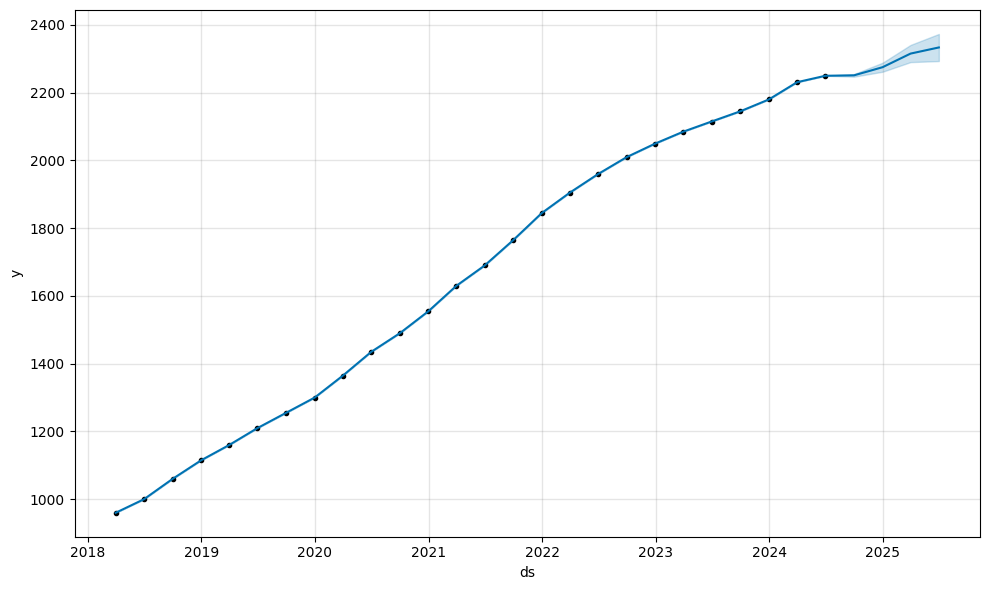

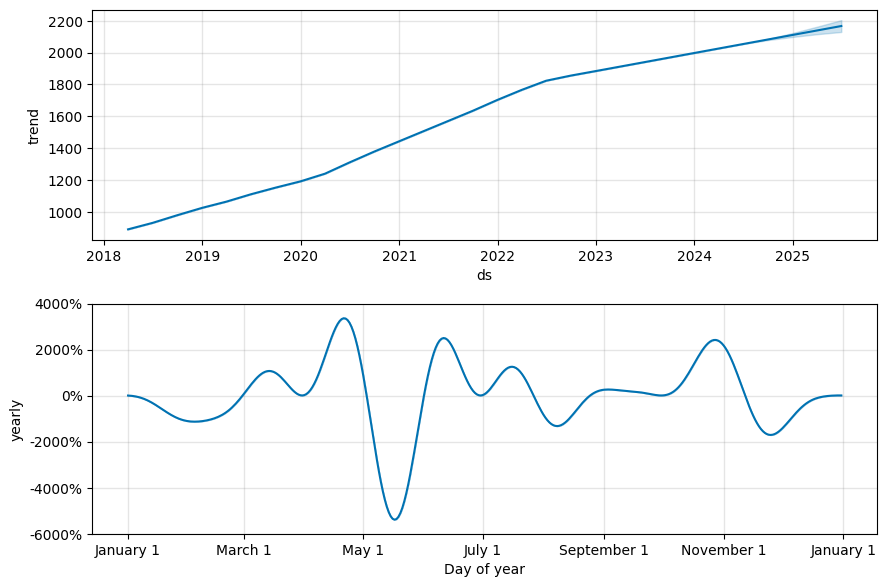

17:54:21 - cmdstanpy - INFO - Chain [1] start processing
17:54:32 - cmdstanpy - INFO - Chain [1] done processing


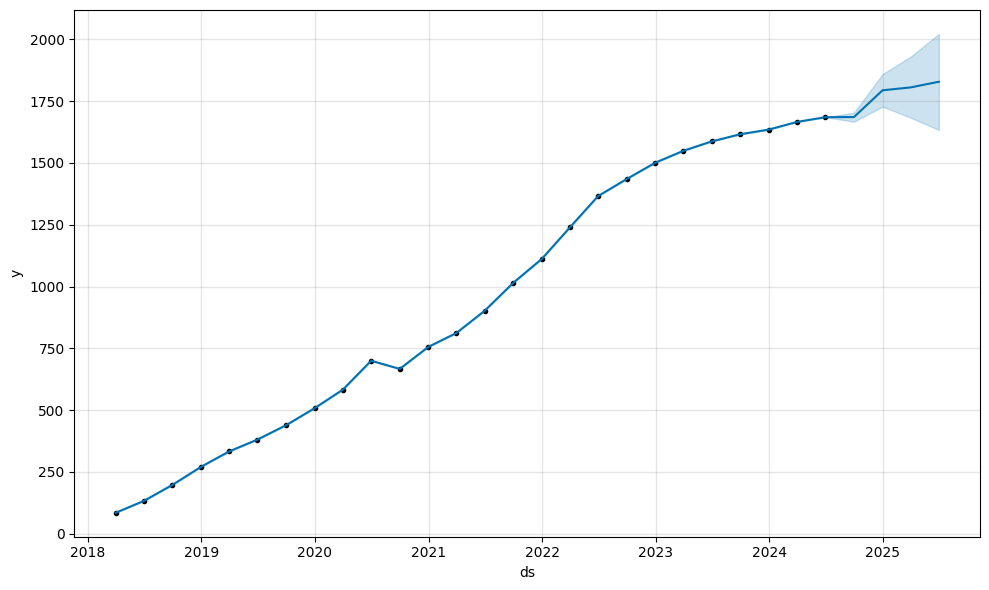

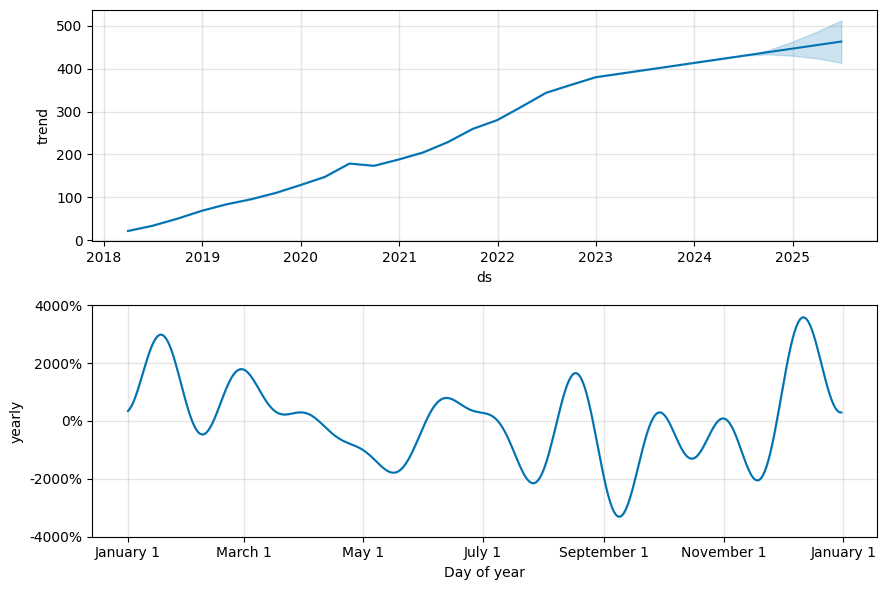

In [5]:
# 2. Modelagem/Treino
ig_maus_forecast_prophet_model, ig_maus_prophet_model = fit_preditct_prophet(data, 'ig_maus')
tk_maus_forecast_prophet_model, tk_maus_prophet_model = fit_preditct_prophet(data, 'tk_maus')

In [6]:
# criar um df que tenha as previsões
ig_pred = ig_maus_forecast_prophet_model[['ds', 'yhat']].tail(8)
tk_pred = tk_maus_forecast_prophet_model[['ds', 'yhat']].tail(8)

In [8]:
tk_pred

,ds,yhat
22,2023-09-30,1615.994991
23,2023-12-31,1635.004166
24,2024-03-31,1666.001665
25,2024-06-30,1684.995038
26,2024-09-30,1685.593091
27,2024-12-31,1793.851213
28,2025-03-31,1805.443847
29,2025-06-30,1828.320577


In [ ]:
# 3. Avaliação do Modelo
evaluate_model(data['ig_maus'], ig_maus_forecast_prophet_model_v1)
evaluate_model(data['tk_maus'], tk_maus_forecast_prophet_model_v1)

In [ ]:
# Salva o modelo treinado
with open('models/ig_maus_prophet_model_v1', 'wb') as f:
    pickle.dump(ig_maus_prophet_model_v1, f)

with open('models/tk_maus_prophet_model_v1', 'wb') as f:
    pickle.dump(tk_maus_prophet_model_v1, f)

## Revenues Prophet

In [ ]:
data

In [ ]:
# 1. Avaliação dos Pressupostos
evaluate_assumptions(data, 'ig_revs')
evaluate_assumptions(data, 'tk_revs')

In [ ]:
# 2. Modelagem/Treino
ig_revenue_forecast_prophet_model_v1, ig_revenue_prophet_model_v1 = fit_preditct_prophet(data, 'ig_revs')
tk_revenue_forecast_prophet_model_v1, tk_revenue_prophet_model_v1 = fit_preditct_prophet(data, 'tk_revs')

In [ ]:
# 3. Avaliação do Modelo
evaluate_model(data['ig_revs'], ig_revenue_forecast_prophet_model_v1)
evaluate_model(data['tk_revs'], tk_revenue_forecast_prophet_model_v1)

In [ ]:
# Salva o modelo treinado
with open('models/ig_revenue_prophet_model_v1', 'wb') as f:
    pickle.dump(ig_revenue_prophet_model_v1, f)

with open('models/tk_revenue_prophet_model_v1', 'wb') as f:
    pickle.dump(tk_revenue_prophet_model_v1, f)